In [1]:
#!yes |conda install cuda -c nvidia
!conda install -y cuda -c nvidia
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# !pip3 install tensorflow_text>=2.0.0rc0
!pip install tensorflow_text
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

import os

import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
import collections
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cuda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2022.6.15          |     pyhd8ed1ab_1         154 KB  conda-forge
    cuda-11.7.1                |             

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

1. [quran dataset](https://www.kaggle.com/datasets/alizahidraja/quran-english)
2. [bible dataset](https://www.kaggle.com/datasets/phyred23/bibleverses)

In [2]:
en_quran = pd.read_csv('../input/quran-english/Quran_English.csv')
en_quran.head(1)

,Name,Surah,Ayat,Verse
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc..."


In [3]:
kjv = pd.read_csv('/kaggle/input/bibleverses/bible_data_set.csv')
kjv.book.unique()

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi',
       'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans',
       '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians',
       'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians',
       '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James',
       '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
       'Revelation'], dtype=object)

In [4]:
old = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum','Habakkuk','Zephaniah','Haggai','Zechariah','Malachi']

len(old) 


39

In [5]:
old_kjv = kjv[kjv.book.isin(old)]

en_torah = old_kjv.copy()

In [6]:
len(kjv) - len(old_kjv)


7957

In [7]:
en_torah.head(1)

,citation,book,chapter,verse,text
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...


In [8]:
max_len = en_quran.Verse.str.split().map(lambda x: len(x))
max_len = max_len.tolist()
max_val =  max(max_len)
print(max_val)
max_idx = max_len.index(max_val)
max_idx

273


288

In [9]:
en_torah.text[10]

'And God said, Let the earth bring forth grass, the herb yielding seed, and the fruit tree yielding fruit after his kind, whose seed is in itself, upon the earth: and it was so. \n'

In [10]:
max_len = en_torah.text.str.split().map(lambda x: len(x))
max_len = max_len.tolist()
max_val =  max(max_len)
print(max_val)
max_idx = max_len.index(max_val)
max_idx

86


12826

In [11]:
def wordLemmatizer(data):
    tag_map = collections.defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    clean_k =pd.DataFrame()
    word_Lemmatized = WordNetLemmatizer()
    for index,entry in tqdm(enumerate(data)):
        
        Final_words = []
        for word, tag in pos_tag(entry):
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        
        clean_k.loc[index,'Keyword_final'] = str(Final_words)
    clean_k=clean_k.replace(to_replace ="'", value = '', regex = True)
    clean_k=clean_k.replace(to_replace =" ", value = '', regex = True)
    clean_k=clean_k.replace(to_replace ="\[", value = '', regex = True)
    clean_k=clean_k.replace(to_replace ='\]', value = '', regex = True)
    return clean_k



In [12]:
%%time
#from -> https://github.com/alizahidraja/QURAN-NLP/blob/master/Quran%2C%20Tafseer%20%26%20NLP.ipynb

en_torah['useful_info'] = en_torah.text.astype(str) 
en_torah["useful_info"] = en_torah.useful_info.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) 
#remove punctuation
en_torah.useful_info =en_torah.useful_info.replace(to_replace='-',value=' ',regex=True)
en_torah.useful_info =en_torah.useful_info.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
en_torah.useful_info =en_torah.useful_info.replace(to_replace='  ',value='',regex=True)   #remove double white space  
en_torah.useful_info =en_torah.useful_info.replace(to_replace="'",value='',regex=True)   


en_torah.useful_info = en_torah.useful_info.apply(lambda x:x.strip().lower())  # Ltrim and Rtrim of whitespace
en_torah["info_tokenize"]= [word_tokenize(entry) for entry in tqdm(en_torah["useful_info"])] 


en_torah["Keyword_final"] = wordLemmatizer(en_torah['info_tokenize'])
en_torah.head()

100%|██████████| 23145/23145 [00:03<00:00, 6832.85it/s]
23145it [02:11, 175.73it/s]


CPU times: user 2min 4s, sys: 11.4 s, total: 2min 15s
Wall time: 2min 17s


,citation,book,chapter,verse,text,useful_info,info_tokenize,Keyword_final
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,in the beginning god created the heaven and th...,"[in, the, beginning, god, created, the, heaven...","beginning,god,create,heaven,earth"
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",and the earth was without form and void and da...,"[and, the, earth, was, without, form, and, voi...","earth,without,form,void,darkness,upon,face,dee..."
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",and god said let there be light and there was ...,"[and, god, said, let, there, be, light, and, t...","god,say,let,light,light"
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",and god saw the light that it was good and god...,"[and, god, saw, the, light, that, it, was, goo...","god,saw,light,good,god,divide,light,darkness"
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",and god called the light day and the darkness ...,"[and, god, called, the, light, day, and, the, ...","god,call,light,day,darkness,call,night,evening..."


In [13]:
%%time

en_quran['useful_info'] = en_quran.Verse.astype(str) 
en_quran["useful_info"] = en_quran.useful_info.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) 
#remove punctuation
en_quran.useful_info =en_quran.useful_info.replace(to_replace='-',value=' ',regex=True)
en_quran.useful_info =en_quran.useful_info.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
en_quran.useful_info =en_quran.useful_info.replace(to_replace='  ',value='',regex=True)   #remove double white space  
en_quran.useful_info =en_quran.useful_info.replace(to_replace="'",value='',regex=True)   


en_quran.useful_info = en_quran.useful_info.apply(lambda x:x.strip().lower())  # Ltrim and Rtrim of whitespace
en_quran["info_tokenize"]= [word_tokenize(entry) for entry in tqdm(en_quran["useful_info"])] 


en_quran["Keyword_final"] = wordLemmatizer(en_quran['info_tokenize'])
en_quran.head()

100%|██████████| 6236/6236 [00:01<00:00, 3483.18it/s]
6236it [00:30, 204.37it/s]


CPU times: user 29.6 s, sys: 2.83 s, total: 32.4 s
Wall time: 32.6 s


,Name,Surah,Ayat,Verse,useful_info,info_tokenize,Keyword_final
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc...",in the name of allah the beneficent the merciful.,"[in, the, name, of, allah, the, beneficent, th...","name,allah,beneficent,merciful"
1,The Opening,1,2,"Praise be to Allah, Lord of the Worlds,",praise be to allah lord of the worlds,"[praise, be, to, allah, lord, of, the, worlds]","praise,allah,lord,world"
2,The Opening,1,3,"The Beneficent, the Merciful.",the beneficent the merciful.,"[the, beneficent, the, merciful, .]","beneficent,merciful"
3,The Opening,1,4,"Owner of the Day of Judgment,",owner of the day of judgment,"[owner, of, the, day, of, judgment]","owner,day,judgment"
4,The Opening,1,5,Thee (alone) we worship; Thee (alone) we ask f...,thee alone we worship thee alone we ask for help,"[thee, alone, we, worship, thee, alone, we, as...","thee,alone,worship,thee,alone,ask,help"


In [14]:
# torah_list = en_torah.Keyword_final.tolist()
# quran_list = en_quran.Keyword_final.tolist()

torah_list = en_torah.text.tolist()
quran_list = en_quran.Verse.tolist()
len(torah_list),len(quran_list)

(23145, 6236)

In [15]:
drop_columns = ['useful_info','info_tokenize','Keyword_final']
en_torah = en_torah.drop(drop_columns, axis=1)
en_quran = en_quran.drop(drop_columns, axis=1)


In [16]:
%%time

# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#https://tfhub.dev/google/universal-sentence-encoder-large/5

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")



CPU times: user 17.4 s, sys: 3.36 s, total: 20.8 s
Wall time: 21.6 s


In [17]:
sim_quran_torah = en_torah.copy()
sim_quran_torah = sim_quran_torah.rename(columns={"citation": "t_citation", "book": "t_book", "chapter": "t_chapter", "verse": "t_verse", "text": "t_text"})


sim_quran_torah['q_Name'] = "Quran Surah Name"
sim_quran_torah['q_Surah'] = "Quran Surah Number"
sim_quran_torah['q_Ayat'] = "Quran Ayat Number of corresponding Surah"
sim_quran_torah['q_Verse'] = "Quranic Verse of Corresponding surah and ayat"

sim_quran_torah['similarity_score'] = 0.0

sim_quran_torah.head(1)

,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,Quran Surah Name,Quran Surah Number,Quran Ayat Number of corresponding Surah,Quranic Verse of Corresponding surah and ayat,0.0


In [18]:
def embed_sentences(texts):
    batch_size =  32
    index      = 0
    text_emb    = []

    while index*batch_size < len(texts):
        text_emb.append(embed(texts[index*batch_size:(index+1)*batch_size]))
        index += 1  

    emb = np.vstack(text_emb)
    print( emb.shape )
    del text_emb
   
    return emb

In [19]:
%%time
torah_batch_embeddings = embed_sentences(torah_list)
quran_batch_embeddings = embed_sentences(quran_list)


(23145, 512)
(6236, 512)
CPU times: user 41.7 s, sys: 2.95 s, total: 44.6 s
Wall time: 50.2 s


In [20]:
dot_score= np.inner(torah_batch_embeddings[0], quran_batch_embeddings[0])
dot_score

0.12437436

In [21]:
%%time

for i in range(len(torah_batch_embeddings)):
    best_score = 0.0
    idx = 0
    for j in range(len(quran_batch_embeddings)):

        # Compute similarity matrix. Higher score indicates greater similarity.
        dot_score= np.inner(torah_batch_embeddings[i], quran_batch_embeddings[j])
#         print(dot_score)
        if(dot_score>best_score):
            best_score = dot_score
            idx = j


    sim_quran_torah.loc[i, 'similarity_score'] = best_score
    sim_quran_torah.loc[i, 'q_Name'] = en_quran.loc[idx, 'Name']
    sim_quran_torah.loc[i, 'q_Surah'] = en_quran.loc[idx, 'Surah']
    sim_quran_torah.loc[i, 'q_Ayat'] = en_quran.loc[idx, 'Ayat']
    sim_quran_torah.loc[i, 'q_Verse'] = en_quran.loc[idx, 'Verse']
    
sim_quran_torah.head()

CPU times: user 6min 25s, sys: 326 ms, total: 6min 25s
Wall time: 6min 26s


,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,The Prophets,21,16,We created not the heaven and the earth and al...,0.622596
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",Cattle,6,59,And with Him are the keys of the Invisible. No...,0.413075
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",Noah,71,16,"And hath made the moon a light therein, and ma...",0.587231
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",Those Who Drag Forth,79,29,"And He made dark the night thereof, and He bro...",0.519808
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",The Prophets,21,33,And He it is Who created the night and the day...,0.599696


In [22]:

sim_quran_torah = sim_quran_torah.sort_values(by=['similarity_score'], ascending=False)

In [23]:
sim_quran_torah.to_csv("google_USE_similarities_between_quran_and_torah.csv",index = False)

In [24]:
sim_quran_torah['similarity_score'] =sim_quran_torah['similarity_score'] * 100
sim_quran_torah['similarity_score'] =sim_quran_torah['similarity_score'].astype(int)
sim_quran_torah

,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
1260,Genesis 42:8,Genesis,42,8,"And Joseph knew his brethren, but they knew no...",Joseph,12,58,And Joseph’s brethren came and presented thems...,81
2998,Leviticus 11:1,Leviticus,11,1,"And the LORD spake unto Moses and to Aaron, sa...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",75
3053,Leviticus 13:1,Leviticus,13,1,"And the LORD spake unto Moses and Aaron, sayin...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
4134,Numbers 14:26,Numbers,14,26,"And the LORD spake unto Moses and unto Aaron, ...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
1693,Exodus 7:8,Exodus,7,8,"And the LORD spake unto Moses and unto Aaron, ...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
...,...,...,...,...,...,...,...,...,...,...
8683,2 Samuel 23:30,2 Samuel,23,30,"Benaiah the Pirathonite, Hiddai of the brooks ...",Mary,19,1,Kaf. Ha. Ya. A’in. Sad.,21
7513,1 Samuel 14:5,1 Samuel,14,5,The forefront of the one was situate northward...,Mary,19,69,Then We shall pluck out from every sect whiche...,20
12622,Nehemiah 11:34,Nehemiah,11,34,"Hadid, Zeboim, Neballat, \n",The Emissaries,77,32,"Lo! it throweth up sparks like the castles,",19
10304,1 Chronicles 1:52,1 Chronicles,1,52,"Duke Aholibamah, duke Elah, duke Pinon, \n",The Mansions of the Stars,85,15,"Lord of the Throne of Glory,",19


<AxesSubplot:>

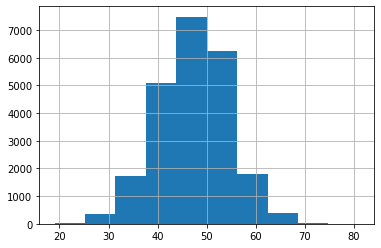

In [25]:
sim_quran_torah['similarity_score'].hist()

In [26]:
sim_quran_torah.t_text[0]

'In the beginning God created the heaven and the earth. \n'

In [27]:
sim_quran_torah.q_Verse[0]

'We created not the heaven and the earth and all that is between them in play.'

In [28]:
sim_quran_torah.similarity_score[0]

62

In [29]:
df = sim_quran_torah[sim_quran_torah['similarity_score']>60]
len(df)

758

In [30]:
df = sim_quran_torah[sim_quran_torah['similarity_score']>54]
len(df)
df.to_csv("most_sim_pairs_google_USE_quran_and_torah.csv",index = False)

In [31]:
df

,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
1260,Genesis 42:8,Genesis,42,8,"And Joseph knew his brethren, but they knew no...",Joseph,12,58,And Joseph’s brethren came and presented thems...,81
2998,Leviticus 11:1,Leviticus,11,1,"And the LORD spake unto Moses and to Aaron, sa...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",75
3053,Leviticus 13:1,Leviticus,13,1,"And the LORD spake unto Moses and Aaron, sayin...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
4134,Numbers 14:26,Numbers,14,26,"And the LORD spake unto Moses and unto Aaron, ...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
1693,Exodus 7:8,Exodus,7,8,"And the LORD spake unto Moses and unto Aaron, ...",Those Who Set The Ranks,37,114,"And We verily gave grace unto Moses and Aaron,",74
...,...,...,...,...,...,...,...,...,...,...
1324,Genesis 43:34,Genesis,43,34,And he took and sent messes unto them from bef...,Repentance,9,76,"Yet when He gave them of His bounty, they hoar...",55
1240,Genesis 41:45,Genesis,41,45,And Pharaoh called Joseph's name Zaphnathpaane...,Joseph,12,21,And he of Egypt who purchased him said unto hi...,55
18894,Isaiah 64:9,Isaiah,64,9,"Be not wroth very sore, O LORD, neither rememb...",She That is to be Examined,60,5,Our Lord! Make us not a prey for those who dis...,55
1455,Genesis 48:4,Genesis,48,4,"And said unto me, Behold, I will make thee fru...",The Believers,23,29,And say: My Lord! Cause me to land at a blesse...,55
